In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12720203.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


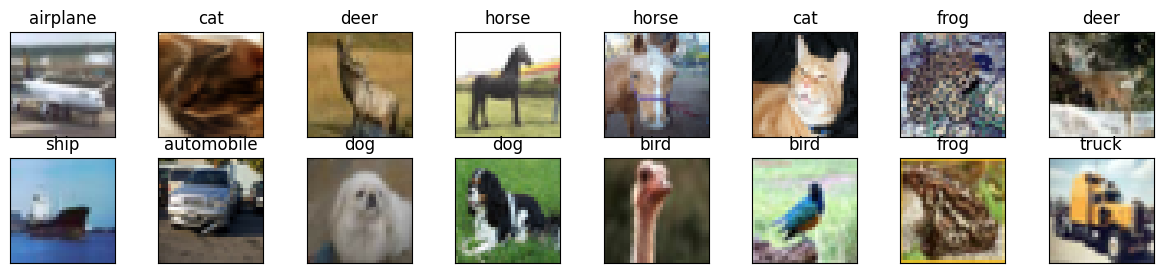

In [7]:
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# 获取一批样本
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# 显示图像，标题为类名
fig = plt.figure(figsize=(15, 3))
# 显示16张图片
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.bn1 = nn.BatchNorm2d(6)  # BatchNorm for conv1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.bn2 = nn.BatchNorm2d(16)  # BatchNorm for conv2
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.bn3 = nn.BatchNorm1d(120)  # BatchNorm for fc1
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.bn4 = nn.BatchNorm1d(84)  # BatchNorm for fc2
        self.fc3 = nn.Linear(84, 10, bias=False)
        # Note: No batch norm after fc3 since it's the output layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.gelu(self.bn1(self.conv1(x))))  # Use GELU instead of ReLU
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))  # Use GELU instead of ReLU
        x = x.view(-1, 16 * 5 * 5)
        x = F.gelu(self.bn3(self.fc1(x)))  # Use GELU instead of ReLU
        x = F.gelu(self.bn4(self.fc2(x)))  # Use GELU instead of ReLU
        x = self.fc3(x)
        return x

net = Net().to(device)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # 3表示输入是3通道
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)


        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

net = Net().to(device)

In [13]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # get 1 batch worth of image predictions (i.e. 4 predictions of 10 each)
            other, predicted = torch.max(outputs.data, 1) # other == values, predicted == indicies
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break

    return 100 * correct / total

In [14]:
train(net, trainloader)

[1,  2000] loss: 0.630
[2,  2000] loss: 0.606
[3,  2000] loss: 0.586
[4,  2000] loss: 0.558
[5,  2000] loss: 0.538
[6,  2000] loss: 0.524
[7,  2000] loss: 0.507
[8,  2000] loss: 0.483
[9,  2000] loss: 0.468
[10,  2000] loss: 0.465
[11,  2000] loss: 0.437
[12,  2000] loss: 0.436
[13,  2000] loss: 0.423
[14,  2000] loss: 0.407
[15,  2000] loss: 0.392
[16,  2000] loss: 0.389
[17,  2000] loss: 0.376
[18,  2000] loss: 0.357
[19,  2000] loss: 0.349
[20,  2000] loss: 0.350
Finished Training


Now that the CNN has been trained, let's test it on our test dataset.

In [15]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 61.56%


In [16]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


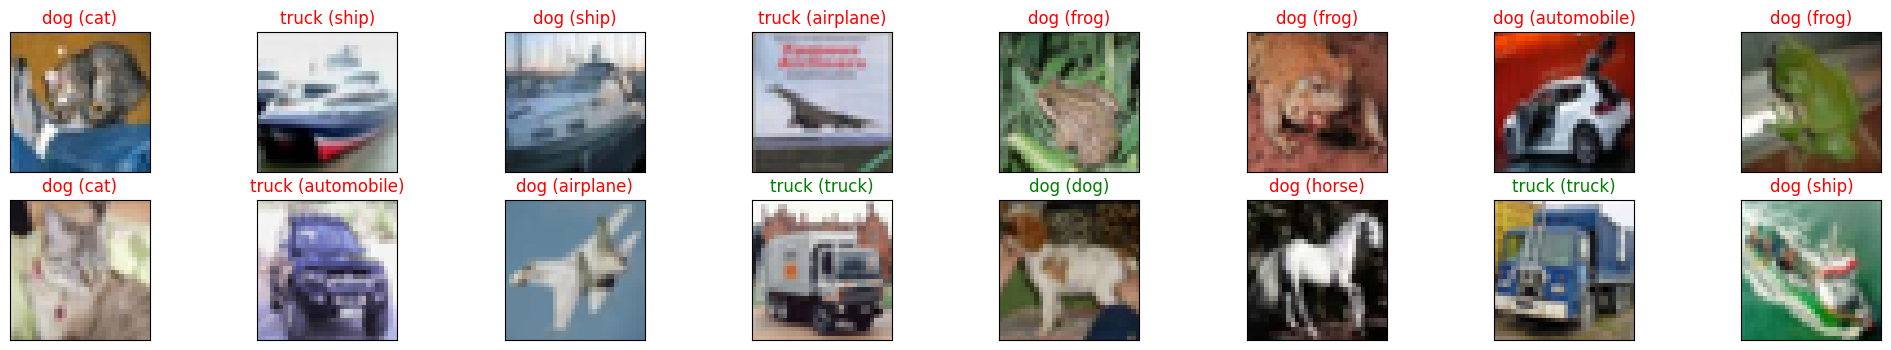

In [18]:
model = model.cuda()

# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

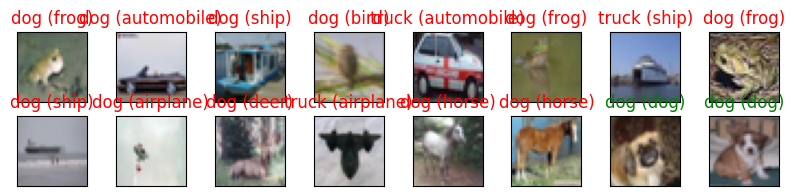

In [37]:
# obtain one batch of test images
# 获取下一个批次的测试图片
images, labels = next(dataiter)  # 不需要重新创建dataiter

# 将图片转移到GPU上（如果可用）
images = images.cuda()

# 获取模型输出
output = model(images)

# 转换输出概率到预测的类别
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

# 绘制图片及其预测的和真实的类别
fig = plt.figure(figsize=(10, 2))
for idx in np.arange(16):  # 假设每个批次至少有4个样本
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])  # 显示图片
    # 设置标题：预测类别（真实类别），正确预测为绿色，错误为红色
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))